In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel as parallel
import torch.distributed as distributed
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import shap
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes
# import cudf
# import dask_cudf
# from dask_ml.preprocessing import StandardScaler
# from dask_ml.impute import SimpleImputer
# from dask_ml.wrappers import ParallelPostFit
# from dask_ml.wrappers import Incremental
# from sklearn.svm import SVC
# import cuml
from torch.nn import init
import pickle
import dask
from dask import dataframe as dd
import dask.array as da
# import dask_ml.datasets
# import dask_ml.cluster
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# cluster = LocalCUDACluster()
# client = Client(cluster)
# client

In [4]:
data = pd.read_csv("intersect_4DNFI18UHVRO.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [5]:
data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000272455,-0.028341,ENSR00000000202,-0.000818,140000,48
1,ENSG00000224051,-0.012343,ENSR00000000202,-0.000818,230000,32
2,ENSG00000224870,0.005104,ENSR00000000202,-0.000818,150000,58
3,ENSG00000197785,0.055437,ENSR00000000202,-0.000818,40000,121
4,ENSG00000272512,-0.025277,ENSR00000000202,-0.000818,560000,12
...,...,...,...,...,...,...
85625,ENSR00000144311,-0.147444,ENSG00000008735,-0.045636,26700000,1
85626,ENSR00000146851,0.470797,ENSG00000008735,-0.045636,7710000,1
85627,ENSR00000144050,-0.134191,ENSG00000008735,-0.045636,28870000,1
85628,ENSR00000146851,0.470797,ENSG00000100299,-0.279448,7720000,3


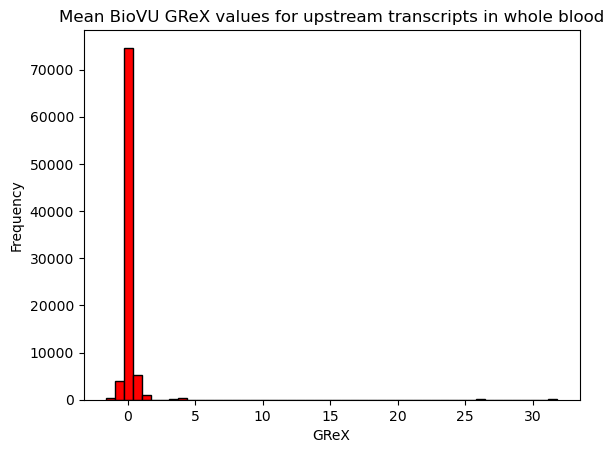

In [6]:
#Plot the distribution of the mean BioVU GReX values for transcript 1 in whole blood
plt.hist(data[['expression1']], bins=50, edgecolor='k', color='red')
plt.xlabel('GReX')
plt.ylabel('Frequency')
plt.title('Mean BioVU GReX values for upstream transcripts in whole blood')
plt.savefig("whole_blood_grex_upstream_dist.png", dpi=300)

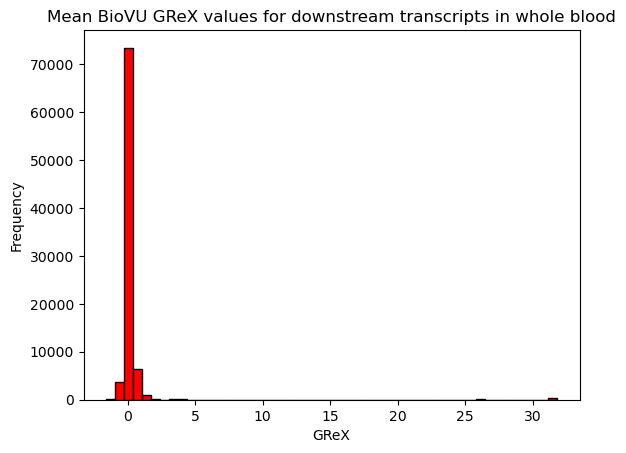

In [7]:
#Plot the distribution of the mean BioVU GReX values for transcript 2 in whole blood
plt.hist(data[['expression2']], bins=50, edgecolor='k', color='red')
plt.xlabel('GReX')
plt.ylabel('Frequency')
plt.title('Mean BioVU GReX values for downstream transcripts in whole blood')
plt.savefig("whole_blood_grex_downstream_dist.png", dpi=300)

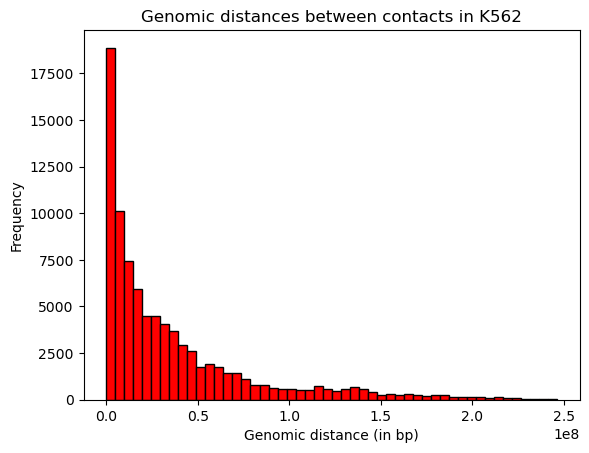

In [7]:
#Plot genomic distances in K562
plt.hist(data[['dist']], bins=50, edgecolor='k', color='red')
plt.xlabel('Genomic distance (in bp)')
plt.ylabel('Frequency')
plt.title('Genomic distances between contacts in K562')
plt.savefig("k562_distance_contact_dist.png", dpi=300)

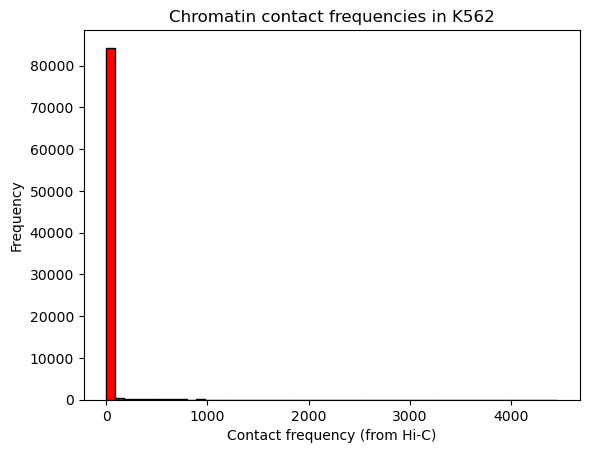

In [8]:
#Plot contact frequencies in K562
plt.hist(data[['norm_contacts']], bins=50, edgecolor='k', color='red')
plt.xlabel('Contact frequency (from Hi-C)')
plt.ylabel('Frequency')
plt.title('Chromatin contact frequencies in K562')
plt.savefig("k562_contact_freq.png", dpi=300)

In [78]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [79]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([51378])

In [80]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([17126])

In [82]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([17126, 2])

In [83]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [84]:
torch.cuda.is_available()

True

In [15]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = NeuralNetRegressor(  #Use NeuralNetRegressor for regression
    Net,
    criterion=nn.MSELoss,  #Use Mean Squared Error loss for regression
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,  #Output size should be 1 for regression
    verbose=False,
    device="cuda:1",
)

#Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    #'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RMSE: 67.778471 using {'module__hidden_size': 100}
68.319749 (632.118123) with: {'module__hidden_size': 10}
68.178362 (622.968709) with: {'module__hidden_size': 20}
68.109881 (631.566900) with: {'module__hidden_size': 30}
68.090193 (608.541893) with: {'module__hidden_size': 40}
68.008508 (611.773218) with: {'module__hidden_size': 50}
67.922334 (611.011435) with: {'module__hidden_size': 60}
67.896747 (619.889227) with: {'module__hidden_size': 70}
67.878604 (607.920749) with: {'module__hidden_size': 80}
67.874954 (611.252212) with: {'module__hidden_size': 90}
67.778471 (613.526832) with: {'module__hidden_size': 100}


In [17]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = NeuralNetRegressor(  #Use NeuralNetRegressor for regression
    Net,
    criterion=nn.MSELoss,  #Use Mean Squared Error loss for regression
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,  #Output size should be 1 for regression
    verbose=False,
    device="cuda:1",
)

#Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [100, 110, 120, 130, 140, 150],
    #'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best RMSE: 67.813719 using {'module__hidden_size': 130}
67.830033 (609.349537) with: {'module__hidden_size': 100}
67.848856 (612.903256) with: {'module__hidden_size': 110}
67.833268 (608.571578) with: {'module__hidden_size': 120}
67.813719 (615.200824) with: {'module__hidden_size': 130}
67.875480 (620.688042) with: {'module__hidden_size': 140}
67.836367 (608.489712) with: {'module__hidden_size': 150}


In [19]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__output_size=1,
    verbose=False,
    device = "cuda:1"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RMSE: 64.661705 using {'module__num_hidden_layers': 2}
67.819929 (624.505413) with: {'module__num_hidden_layers': 1}
64.661705 (722.000376) with: {'module__num_hidden_layers': 2}
64.825653 (524.938129) with: {'module__num_hidden_layers': 3}
66.923369 (764.218562) with: {'module__num_hidden_layers': 4}
69.147176 (624.360000) with: {'module__num_hidden_layers': 5}
69.147191 (624.358034) with: {'module__num_hidden_layers': 6}
69.147798 (624.351615) with: {'module__num_hidden_layers': 7}
69.147087 (624.309083) with: {'module__num_hidden_layers': 8}
69.147448 (624.355167) with: {'module__num_hidden_layers': 9}
69.147823 (624.324581) with: {'module__num_hidden_layers': 10}


In [21]:
#Optimizng the batch size and number of epochs
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:1"
)

#Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RMSE: 63.648762 using {'batch_size': 60, 'max_epochs': 50}
66.184205 (599.031113) with: {'batch_size': 10, 'max_epochs': 10}
66.505668 (552.518837) with: {'batch_size': 10, 'max_epochs': 20}
65.501220 (617.535130) with: {'batch_size': 10, 'max_epochs': 30}
65.731280 (523.147134) with: {'batch_size': 10, 'max_epochs': 40}
66.204948 (626.014043) with: {'batch_size': 10, 'max_epochs': 50}
66.092930 (582.700382) with: {'batch_size': 20, 'max_epochs': 10}
65.746840 (552.434821) with: {'batch_size': 20, 'max_epochs': 20}
65.317601 (553.352518) with: {'batch_size': 20, 'max_epochs': 30}
64.883323 (596.258509) with: {'batch_size': 20, 'max_epochs': 40}
64.830051 (651.335236) with: {'batch_size': 20, 'max_epochs': 50}
65.708214 (578.330544) with: {'batch_size': 40, 'max_epochs': 10}
65.729380 (532.148788) with: {'batch_size': 40, 'max_epochs': 20}
64.806389 (610.102294) with: {'batch_size': 40, 'max_epochs': 30}
64.319332 (608.4

In [22]:
# #Optimizng the batch size and number of epochs
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.num_hidden_layers = num_hidden_layers - 1
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
#         self.fc2 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         for i in range(self.num_hidden_layers):
#             x = torch.relu(self.hidden_layers[i](x))
#         x = self.fc2(x)
#         return x
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.Adam,
#     module__input_size=input_shape,
#     module__hidden_size=120,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     verbose=False,
#     device = "cuda:2"
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'batch_size':[80, 90, 100, 110, 120],
#     'max_epochs': [50, 60, 70, 80, 90, 100],
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="r2",
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [24]:
#Optimizng the training optimization algorithm
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=60,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:1"
)

#Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam],
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.002, 0.005, 0.006, 0.007, 0.008, 0.0085, 0.009, 0.01, 0.1, 0.2, 0.3]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 98 candidates, totalling 490 fits


/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213,

Best RMSE: 63.430325 using {'optimizer': <class 'torch.optim.nadam.NAdam'>, 'optimizer__lr': 0.002}
66.232004 (623.799037) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0001}
68.930107 (609.859481) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0005}
69.023809 (637.585712) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.002}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.005}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.006}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.007}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.008}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0085}
nan (nan) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.009}
nan (nan

In [25]:
#Optimizng how the weights are initialized
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.NAdam,
    max_epochs=50,
    batch_size=60,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.002,
    verbose=False,
    device = "cuda:1"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best RMSE: 62.219811 using {'module__weight_init_hidden': <function kaiming_uniform_ at 0x7f5ef48368c0>, 'module__weight_init_out': <function zeros_ at 0x7f5ef48364d0>}
67.071310 (643.312534) with: {'module__weight_init_hidden': <function uniform_ at 0x7f5ef4836170>, 'module__weight_init_out': <function uniform_ at 0x7f5ef4836170>}
67.594205 (627.858251) with: {'module__weight_init_hidden': <function uniform_ at 0x7f5ef4836170>, 'module__weight_init_out': <function normal_ at 0x7f5ef4836200>}
64.240275 (579.336138) with: {'module__weight_init_hidden': <function uniform_ at 0x7f5ef4836170>, 'module__weight_init_out': <function zeros_ at 0x7f5ef48364d0>}
65.189265 (622.496669) with: {'module__weight_init_hidden': <function uniform_ at 0x7f5ef4836170>, 'module__weight_init_out': <function xavier_normal_ at 0x7f5ef48367a0>}
65.178694 (621.805080) with: {'module__weight_init_hidden': <function uniform_ at 0x7f5ef4836170>, 'module

In [31]:
#Optimizng the activation function
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.NAdam,
    max_epochs=50,
    batch_size=60,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.002,
    module__weight_init_hidden = init.kaiming_uniform_,
    module__weight_init_out = init.zeros_,
    verbose=False,
    device = "cuda:1",
    callbacks=[
        EpochScoring(scoring='neg_mean_squared_error', name='train_rmse', on_train=True, lower_is_better=True),
        EpochScoring(scoring='neg_mean_squared_error', name='valid_rmse', on_train=False, lower_is_better=True)
    ]
)

#Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

#Define the grid search with the appropriate scoring function for RMSE
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",  #Use negative MSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

#Get the RMSE for each fold
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    rmse = np.sqrt(-mean)  #Convert negative MSE to RMSE
    print("%f (%f) with: %r" % (rmse, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best RMSE: 61.802331 using {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
69.138372 (629.418864) with: {'module__activation': <class 'torch.nn.modules.linear.Identity'>}
62.471525 (628.593449) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
62.990498 (598.161374) with: {'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
65.060263 (588.152496) with: {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
61.802331 (564.006033) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
64.774581 (598.779447) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
66.272407 (588.228128) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
62.107827 (621.835102) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
62.117779 (607.632153) with: {'module__activation': <class 'tor

In [28]:
# #Optimizng dropout
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, weight_constraint):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate1)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate2)
#         self.fc3 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         #Manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_out(self.fc3.weight)

#     def forward(self, x):
#         #Maxnorm weight before actual forward pass
#         with torch.no_grad():
#            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc1.weight *= (desired / norm)

#            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc2.weight *= (desired / norm)

#         x = self.activation(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.activation(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.NAdam,
#     max_epochs=50,
#     batch_size=60,
#     module__input_size=input_shape,
#     module__hidden_size=130,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.002,
#     module__weight_init_hidden = init.kaiming_uniform_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.ReLU6,
#     verbose=False,
#     device = "cuda:1",
#     callbacks=[
#         EpochScoring(scoring='neg_mean_squared_error', name='train_rmse', on_train=True, lower_is_better=True),
#         EpochScoring(scoring='neg_mean_squared_error', name='valid_rmse', on_train=False, lower_is_better=True)
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__dropout_rate1': [0.0, 0.1, 0.3, 0.5],
#     'module__dropout_rate2': [0.0, 0.1, 0.3, 0.5],
#     'module__weight_constraint': [1.0, 3.0, 5.0, 7.0, 9.0]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# from sklearn.metrics import make_scorer, mean_squared_error
# import numpy as np

# #Define the grid search with the appropriate scoring function for RMSE
# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="neg_mean_squared_error",  #Use negative MSE as scoring
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# best_mse = -grid_result.best_score_  # Negate the negative MSE to get positive MSE
# best_rmse = np.sqrt(best_mse)  # Take the square root to get RMSE
# print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

# #Get the RMSE for each fold
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     rmse = np.sqrt(-mean)  # Convert negative MSE to RMSE
#     print("%f (%f) with: %r" % (rmse, stdev, param))

In [30]:
# #Optimizng L1 and L2 regularization (without dropout)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, alpha_l1, alpha_l2):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.num_hidden_layers = num_hidden_layers - 1
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         #Manually init weights
#         weight_init_hidden(self.fc1.weight)
#         for i, hidden_layer in enumerate(self.hidden_layers):
#             weight_init_hidden(hidden_layer.weight)
#         weight_init_out(self.fc2.weight)

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         for i in range(self.num_hidden_layers):
#             x = self.activation(self.hidden_layers[i](x))
#         x = self.fc2(x)
#         return x

# #Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         #self.seed_value = seed_value

#     def on_train_begin(self, net, X, y):
#         #torch.manual_seed(self.seed_value)
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         #Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         #Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         #Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         #Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.NAdam,
#     max_epochs=50,
#     batch_size=60,
#     module__input_size=input_shape,
#     module__hidden_size=130,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.002,
#     module__weight_init_hidden = init.kaiming_uniform_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.ReLU6,
#     verbose=False,
#     device = "cuda:1",
#     callbacks=[
#         EpochScoring(scoring='neg_mean_squared_error', name='train_rmse', on_train=True, lower_is_better=True),
#         EpochScoring(scoring='neg_mean_squared_error', name='valid_rmse', on_train=False, lower_is_better=True),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__alpha_l1': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
#     'module__alpha_l2': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# from sklearn.metrics import make_scorer, mean_squared_error
# import numpy as np

# #Define the grid search with the appropriate scoring function for RMSE
# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="neg_mean_squared_error",  #Use negative MSE as scoring
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# # Summarize results
# best_mse = -grid_result.best_score_  #Negate the negative MSE to get positive MSE
# best_rmse = np.sqrt(best_mse)  #Take the square root to get RMSE
# print("Best RMSE: %f using %s" % (best_rmse, grid_result.best_params_))

# #Get the RMSE for each fold
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     rmse = np.sqrt(-mean)  # Convert negative MSE to RMSE
#     print("%f (%f) with: %r" % (rmse, stdev, param))

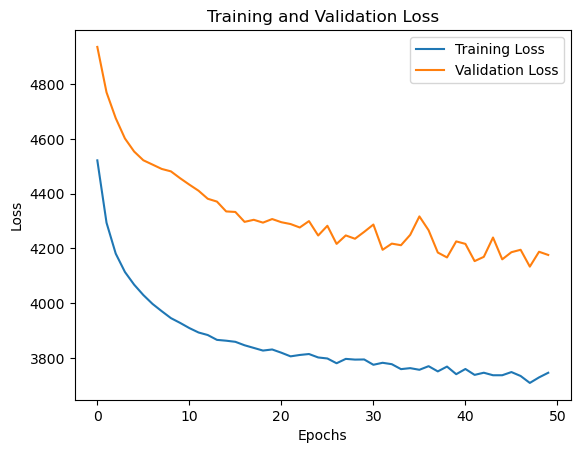

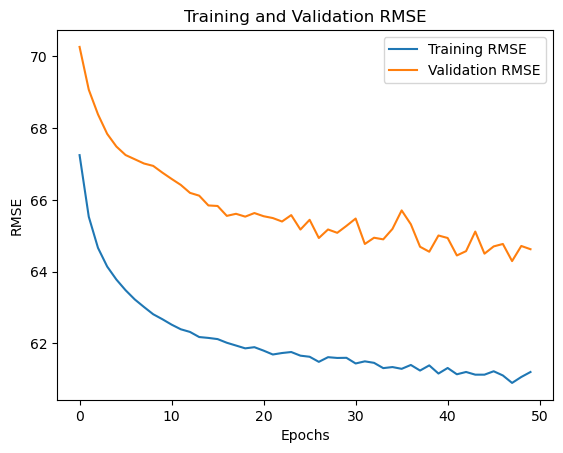

In [32]:
import numpy as np
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_

#Get training and validation loss and RMSE
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']

#Convert the RMSE values to NumPy arrays for proper element-wise operations
train_rmse = np.sqrt(-np.array(best_estimator.history[:, 'train_rmse']))  #Convert negative RMSE to positive
val_rmse = np.sqrt(-np.array(best_estimator.history[:, 'valid_rmse']))    #Convert negative RMSE to positive

#Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Plot the training and validation RMSE curves
plt.figure()
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.show()

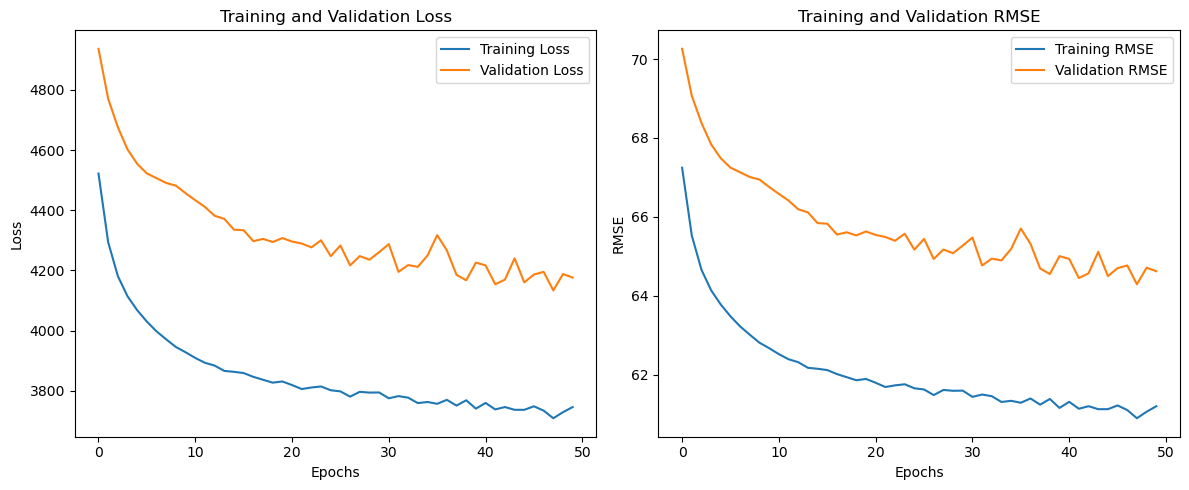

In [33]:
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_

#Get training and validation loss and RMSE
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']

#Convert the RMSE values to NumPy arrays for proper element-wise operations
train_rmse = np.sqrt(-np.array(best_estimator.history[:, 'train_rmse']))  #Convert negative RMSE to positive
val_rmse = np.sqrt(-np.array(best_estimator.history[:, 'valid_rmse']))    #Convert negative RMSE to positive

#Create a figure
plt.figure(figsize=(12, 5))

#Subplot for the loss curves
plt.subplot(1, 2, 1)  #1 row, 2 columns, first plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Subplot for the RMSE curves
plt.subplot(1, 2, 2)  #1 row, 2 columns, second plot
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')

#Show the plots
plt.tight_layout()  #Adjusts space between plots for better layout
#plt.show()
plt.savefig("whole_blood_erna_gene_grex_vs_contact_freq_training_curves_rmse_from_scratch.png", dpi=300)

In [34]:
best_model = grid_result.best_estimator_.module_
#Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'whole_blood_best_rmse_contact_regression_model.h5')

In [38]:
from sklearn.metrics import mean_squared_error

#Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda:1"))

#Compute Root Mean Squared Error
rmse = mean_squared_error(test_labels_final, y_pred.detach().cpu().numpy(), squared=False)

print(rmse)

61.084094323201384


/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
# #Surface plot
# gene1 = test_set_final.numpy()[:,0]
# gene2 = test_set_final.numpy()[:,1]
# gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

# #Convert to torch tensors
# input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda')

# #Get the model's predictions
# with torch.no_grad():
#     predictions_grid = best_model(input_data)
# predictions_grid = predictions_grid.cpu().numpy().reshape(gene1_grid.shape)

# #Plotting the 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(gene1_grid, gene2_grid, predictions_grid, cmap='viridis')

# #Add labels and title
# ax.set_xlabel('Transcript 1 expression')
# ax.set_ylabel('Transcript 2 expression')
# ax.set_zlabel('Predicted contact frequency')
# ax.set_title('eRNA and gene expression versus predicted contact frequency')

# #Add a color bar which maps values to colors.
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# plt.show()

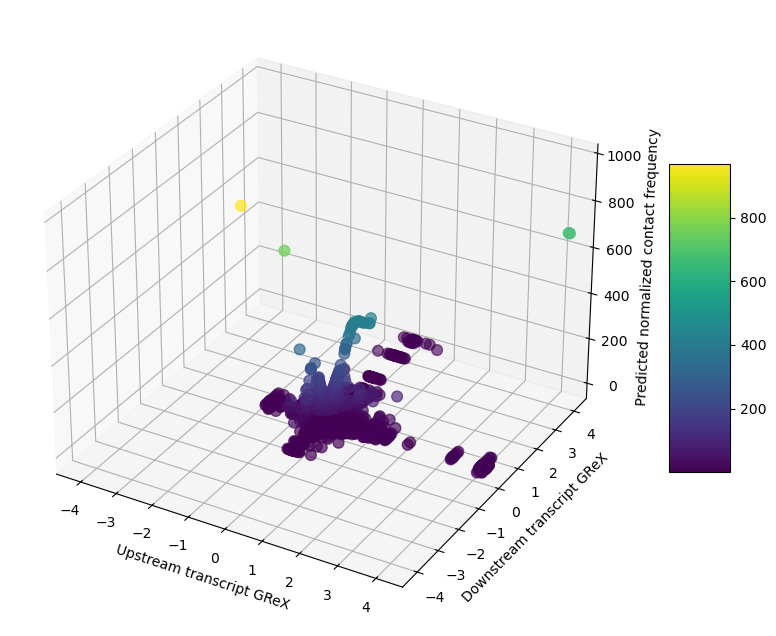

In [41]:
#Scatter plot
gene1 = test_set_final.numpy()[:,0]
gene2 = test_set_final.numpy()[:,1]
gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

#Convert to torch tensors
input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda:1')

#Get the model's predictions
with torch.no_grad():
    predictions = best_model(test_set_final.to('cuda:1')).cpu().numpy()

#Plotting the 3D scatter plot
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

#Using scatter for individual points
scatter = ax.scatter(gene1, gene2, predictions, c=predictions, cmap='viridis', s=60)  #s is the size of the points

#Add labels and title
ax.set_xlabel('Upstream transcript GReX')
ax.set_ylabel('Downstream transcript GReX')
ax.set_zlabel('Predicted normalized contact frequency')
#ax.set_title('eRNA and gene genetically regulated expression versus predicted contact frequency')
ax.set_xlim([-4.5, 4.5])
ax.set_ylim([-4.5, 4.5])

#Add a color bar which maps values to colors.
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

#plt.show()
plt.savefig("whole_blood_erna_gene_grex_vs_contact_freq_rmse.png", dpi=300)

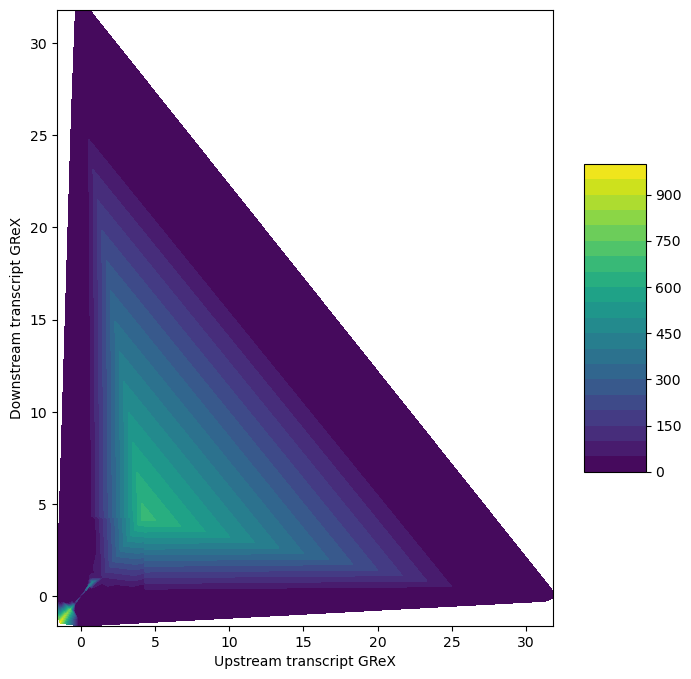

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

#Scatter plot data
gene1 = test_set_final.numpy()[:, 0]
gene2 = test_set_final.numpy()[:, 1]

#Convert to torch tensors
input_data = torch.tensor(np.column_stack((gene1, gene2)), dtype=torch.float32).to('cuda:1')

#Get the model's predictions
with torch.no_grad():
    predictions = best_model(test_set_final.to('cuda:1')).cpu().numpy()

#Remove the extra dimension from predictions
predictions = predictions.squeeze()

#Plotting the 2D contour plot
fig, ax = plt.subplots(figsize=(8, 8))

#Create a Triangulation object
triang = Triangulation(gene1, gene2)

#Using contourf for contour plot
contour = ax.tricontourf(triang, predictions, cmap='viridis', levels=20)

#Add labels and title
ax.set_xlabel('Upstream transcript GReX')
ax.set_ylabel('Downstream transcript GReX')
#ax.set_title('Contour Plot: Predicted normalized contact frequency')

#Set axis limits to include both negative and positive values
ax.set_xlim([gene1.min(), gene1.max()])
ax.set_ylim([gene2.min(), gene2.max()])

#Add a color bar which maps values to colors.
fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)

plt.savefig("whole_blood_erna_gene_grex_contour_plot_rmse.png", dpi=300)
plt.show()

In [43]:
#Sample training data for SHAP
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)

#Create a random sample of training data with which to use as a background sample for SHAP
import torch

#Define the fraction of data you want to sample (e.g., 0.1 for 10%)
sample_fraction = 0.2

#Compute the number of samples
num_samples = int(X.size(0) * sample_fraction)

#Randomly sample without replacement
sample_indices = torch.randperm(X.size(0))[:num_samples]
sample_data = X[sample_indices]

In [45]:
#Testing feature contribution using SHAP
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch
import shap

n_cols = train_set_final.shape[1]
input_shape = n_cols

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_size=input_shape, hidden_size=130, output_size=1, num_hidden_layers=2, weight_init_hidden=init.kaiming_uniform_, weight_init_out=init.zeros_):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.nn.functional.hardsigmoid(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.nn.functional.hardsigmoid(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = Net().to(device)
model.load_state_dict(torch.load('whole_blood_best_rmse_contact_regression_model.h5'))

explainer = shap.DeepExplainer(model, sample_data.to("cuda:1"))

#shap_values = explainer.shap_values(test_set_final)
#y_pred = model(test_set_final)
#auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

#print(auc)

In [47]:
# shap_values = explainer.shap_values(test_set_final)

In [48]:
# #feature_names = exp_file.iloc[:,1:].columns.values.tolist()
# feature_names = ["Upstream transcript GReX", "Downstream transcript GReX"]

# shap.summary_plot(shap_values, test_set_final, feature_names = feature_names)

In [49]:
# #Save the figure at 300 dpi
# feature_names = ["Upstream transcript GReX", "Downstream transcript GReX"]

# shap.summary_plot(shap_values, test_set_final, feature_names=feature_names, plot_size=(10,4), show=False)

# # Save the figure
# # Save the plot
# plt.savefig("whole_blood_shap_plot_erna_gene_grex_log_contacts.png", dpi=300, bbox_inches='tight')
# plt.close()

In [50]:
# global_shap_vals = np.abs(shap_values).mean(axis=0)
# percent_contributions = global_shap_vals / np.sum(global_shap_vals)
# percent_contributions

In [51]:
#Evaluate the proportion of enhancers and genes in the upstream and downstream transcript variables
train = data[["transcript1", "transcript2", "expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [52]:
X = pd.concat([train_set_final, val_set_final], ignore_index=True)

In [53]:
#Compute number of gene-enhancer pairs in the training data
count_gene_enh = X[(X['transcript1'].str.startswith('ENSG')) & (X['transcript2'].str.startswith('ENSR'))].shape[0]
print(count_gene_enh)

34682


In [54]:
#Compute number of enhancer-gene pairs in the training data
count_enh_gene = X[(X['transcript1'].str.startswith('ENSR')) & (X['transcript2'].str.startswith('ENSG'))].shape[0]
print(count_enh_gene)

32133


In [55]:
#Compute number of enhancer-enhancer pairs in the training data
count_enh_enh = X[(X['transcript1'].str.startswith('ENSR')) & (X['transcript2'].str.startswith('ENSR'))].shape[0]
print(count_enh_enh)

1689


In [56]:
#Compute number of gene-gene pairs in the training data
count_gene_gene = X[(X['transcript1'].str.startswith('ENSG')) & (X['transcript2'].str.startswith('ENSG'))].shape[0]
print(count_gene_gene)

0


In [57]:
#Re-generate the entire set of training and test features
train_features = train.copy()
train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_features.pop("transcript1")
train_features.pop("transcript2")

train_features = torch.tensor(np.array(train_features), dtype = torch.float32)
train_labels = torch.tensor(np.array(train_labels), dtype = torch.float32)

In [58]:
test_set_final

,transcript1,transcript2,expression1,expression2
4846,ENSG00000049246,ENSR00000014616,0.030096,-0.098417
34180,ENSG00000111913,ENSR00000206316,-0.012086,-0.043400
448,ENSG00000179051,ENSR00000002510,0.210930,0.035422
39416,ENSG00000186088,ENSR00000328836,0.363709,0.481782
82664,ENSG00000124207,ENSR00000139784,-0.062868,-0.165017
...,...,...,...,...
6330,ENSG00000234741,ENSR00000016873,-0.065559,0.325305
21921,ENSR00000148939,ENSG00000168268,-0.094675,0.238157
52420,ENSG00000134627,ENSR00000046007,-0.036857,-0.092953
56011,ENSG00000274737,ENSR00000057070,-0.118555,0.238674


In [59]:
t1 = test_set_final.pop('transcript1').reset_index()
t2 = test_set_final.pop('transcript2').reset_index()
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([17126, 2])

In [60]:
#Predict outcomes using trained model
model_pred = model(test_set_final.to("cuda:1"))

In [61]:
model_pred

tensor([[-1.3183],
        [-1.3601],
        [-1.2581],
        ...,
        [-1.3583],
        [-1.8741],
        [-1.1264]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [62]:
test_set_final

tensor([[ 0.0301, -0.0984],
        [-0.0121, -0.0434],
        [ 0.2109,  0.0354],
        ...,
        [-0.0369, -0.0930],
        [-0.1186,  0.2387],
        [-0.1623,  0.4973]])

In [63]:
#Compare predictions with outcome
df1 = pd.DataFrame(test_labels_final, columns=['true_val'])
df2 = pd.DataFrame(model_pred.detach().cpu().numpy(), columns=['prediction'])
df3 = pd.DataFrame(t1, columns=['transcript1'])
df4 = pd.DataFrame(t2, columns=['transcript2'])

#Concatenate DataFrames side by side
result = pd.concat([df3, df4, df1, df2], axis=1)
result

result['residual'] = abs(result['prediction'] - result['true_val'])
result['frac_error'] = result['residual'] / result['true_val']

result_sorted = result.sort_values(by='frac_error')

#Save the resulting DataFrame to a CSV file
result_sorted.to_csv('whole_blood_contacts_exp_model_true_vs_pred_rmse.csv', index=False)

In [64]:
result_sorted

,transcript1,transcript2,true_val,prediction,residual,frac_error
6682,ENSR00000108016,ENSG00000269050,1,0.999847,0.000153,0.000153
881,ENSR00000108016,ENSG00000170906,1,1.004140,0.004140,0.004140
15407,ENSG00000140464,ENSR00000079873,1,0.994558,0.005442,0.005442
12810,ENSR00000108016,ENSG00000176472,1,1.006588,0.006588,0.006588
13113,ENSR00000001514,ENSG00000198756,1,1.007029,0.007029,0.007029
...,...,...,...,...,...,...
4362,ENSG00000089169,ENSR00000059235,1,-2.212257,3.212257,3.212257
12367,ENSG00000163041,ENSR00000022897,1,-2.248147,3.248147,3.248147
12091,ENSR00000024385,ENSG00000156113,1,4.253644,3.253644,3.253644
13219,ENSR00000024386,ENSG00000156113,1,4.254647,3.254647,3.254647


In [65]:
np.median(result_sorted['frac_error'])

2.3173828721046448

In [66]:
cer_data = pd.read_csv("intersect_4DNFIWCAQUIK.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [67]:
cer_data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000189339,-0.139152,ENSR00000249824,-0.218757,250000,1
1,ENSG00000008128,-0.007803,ENSR00000249824,-0.218757,220000,5
2,ENSR00000249824,-0.218757,ENSR00000249824,-0.218757,0,148
3,ENSG00000215915,0.020419,ENSR00000249824,-0.218757,480000,1
4,ENSG00000231050,-0.063613,ENSR00000249824,-0.218757,40000,1
...,...,...,...,...,...,...
95696,ENSG00000008735,-0.006373,ENSR00000147753,0.005671,50000,2
95697,ENSG00000100412,0.023097,ENSR00000147753,0.005671,9160000,1
95698,ENSR00000147753,0.005671,ENSG00000079974,-0.007761,110000,1
95699,ENSR00000143576,-0.130605,ENSG00000079974,-0.007761,32990000,1


In [68]:
#Prepare training, validation, and test data
cer_test = cer_data[["expression1", "expression2", "dist", "norm_contacts"]]
cer_test_features = cer_test.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#cer_test_features["norm_contacts"] = np.log(cer_test_features["norm_contacts"])

##Log1p-normalize genomic distances
#cer_test_features["dist"] = np.log1p(cer_test_features["dist"])

cer_test_labels = cer_test_features.pop("norm_contacts")
cer_test_features.pop("dist")
cer_test_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
cer_test_labels = np.array(cer_test_labels)

cer_test_labels

array([  1,   5, 148, ...,   1,   1,   1])

In [69]:
cer_test_features = np.array(cer_test_features)
cer_test_features = torch.tensor(cer_test_features, dtype=torch.float32)
cer_test_features.shape

torch.Size([95701, 2])

In [72]:
from sklearn.metrics import mean_squared_error

#Evaluate performance on test set
y_cer_pred = model(cer_test_features.to("cuda:1"))

#Compute Root Mean Squared Error
rmse = mean_squared_error(cer_test_labels, y_cer_pred.detach().cpu().numpy(), squared=False)

print(rmse)

32.88419009773657


/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from sklearn.model_selection import GridSearchCV, KFold, PredefinedSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import random
from torch.nn import init

#Set seeds for reproducibility
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.NAdam,
    max_epochs=50,
    batch_size=60,
    module__input_size=input_shape,
    module__hidden_size=130,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.002,
    module__weight_init_hidden = init.kaiming_uniform_,
    module__weight_init_out = init.zeros_,
    verbose=False,
    device = "cuda:1",
    callbacks=[
        EpochScoring(scoring='r2', name='train_r2', on_train=True),
        EpochScoring(scoring='r2', name='valid_r2', on_train=False),
    ]
)

#Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.ReLU6]
}

#Create a PredefinedSplit
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold=split_index)

#Define the grid search with RMSE scoring
clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring='r2',  #Use RMSE as scoring
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best: 0.201975 using {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.201975 (0.024359) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
